# Group the spectral peaks of geophone data into regular time-frquency bins

In [1]:
# Imports
from os.path import join
from numpy import linspace
from pandas import read_csv, date_range, Timestamp, Timedelta
from time import time

from utils_basic import SPECTROGRAM_DIR as indir, GEO_STATIONS as stations
from utils_spec import assemble_spec_filename, group_spectral_peaks_regular_bins, read_geo_spectrograms, find_geo_station_spectral_peaks, read_spectral_peaks, save_spectral_peak_bin_counts, bin_counts_to_df
from utils_plot import plot_array_spec_peak_bin_counts, save_figure

In [2]:
# Inputs
# Data
window_length = 1.0
overlap = 0.0
downsample = False
downsample_factor = 60
prom_threshold = 5
rbw_threshold = 0.2

# Grouping
starttime_bins = "2020-01-10T00:00:00"
endtime_bins = "2020-02-02T00:00:00"

time_bin_width = "1s"
freq_bin_width = 1.0 # in Hz
min_freq = 0.0
max_freq = 200.0

count_threshold = 4

# Saving the results
file_format_out = "hdf"

# Plotting
starttime_plot = "2020-01-13T00:00:00"
endtime_plot = "2020-01-14T00:00:00"

size_scale = 30

In [3]:
# Process the detections of each station
if downsample:
    suffix = f"window{window_length:.0f}s_overlap{overlap:.1f}_downsample{downsample_factor:d}_prom{prom_threshold:.0f}db_rbw{rbw_threshold:.1f}"
else:
    suffix = f"window{window_length:.0f}s_overlap{overlap:.1f}_prom{prom_threshold:.0f}db_rbw{rbw_threshold:.1f}"

for i, station in enumerate(stations):
    print(f"Working on {station}...")
    clock1 = time()

    # Read the spectral peaks
    print("Reading the spectral peaks...")
    filename = f"geo_spectral_peaks_{station}_{suffix}.h5"
    inpath = join(indir, filename)
    peak_df = read_spectral_peaks(inpath)
    
    # Group the spectral peaks
    print("Binning the spectral peaks...")
    time_bin_centers, freq_bin_centers, bin_counts = group_spectral_peaks_regular_bins(peak_df, starttime_bins, endtime_bins, time_bin_width = time_bin_width, min_freq = min_freq, max_freq = max_freq, freq_bin_width = freq_bin_width)

    if i == 0:
        bin_counts_sum = bin_counts
    else:
        bin_counts_sum += bin_counts

    clock2 = time()
    elapse = clock2 - clock1
    print(f"Finished processing {station}.")
    print(f"Elapsed time: {elapse} s")
    

Working on A01...
Reading the spectral peaks...
Binning the spectral peaks...
Finished processing A01.
Elapsed time: 152.27132320404053 s
Working on A02...
Reading the spectral peaks...
Binning the spectral peaks...
Finished processing A02.
Elapsed time: 150.96631741523743 s
Working on A03...
Reading the spectral peaks...
Binning the spectral peaks...
Finished processing A03.
Elapsed time: 152.99325370788574 s
Working on A04...
Reading the spectral peaks...
Binning the spectral peaks...
Finished processing A04.
Elapsed time: 152.82117676734924 s
Working on A05...
Reading the spectral peaks...
Binning the spectral peaks...
Finished processing A05.
Elapsed time: 152.2510998249054 s
Working on A06...
Reading the spectral peaks...
Binning the spectral peaks...
Finished processing A06.
Elapsed time: 152.73478364944458 s
Working on A07...
Reading the spectral peaks...
Binning the spectral peaks...
Finished processing A07.
Elapsed time: 151.74493026733398 s
Working on A08...
Reading the spect

In [4]:
# Convert the bin counts to a DataFrame
bin_count_df = bin_counts_to_df(time_bin_centers, freq_bin_centers, bin_counts_sum, count_threshold = count_threshold)

In [6]:
# Save the DataFrame
suffix = f"{suffix}_count{count_threshold}"
file_stem = f"geo_spectral_peak_bin_counts_{suffix}"
save_spectral_peak_bin_counts(bin_count_df, file_stem, file_format_out)

Results saved to /fp/projects01/ec332/data/spectrograms/geo_spectral_peak_bin_counts_window1s_overlap0.0_prom5db_rbw0.2.h5


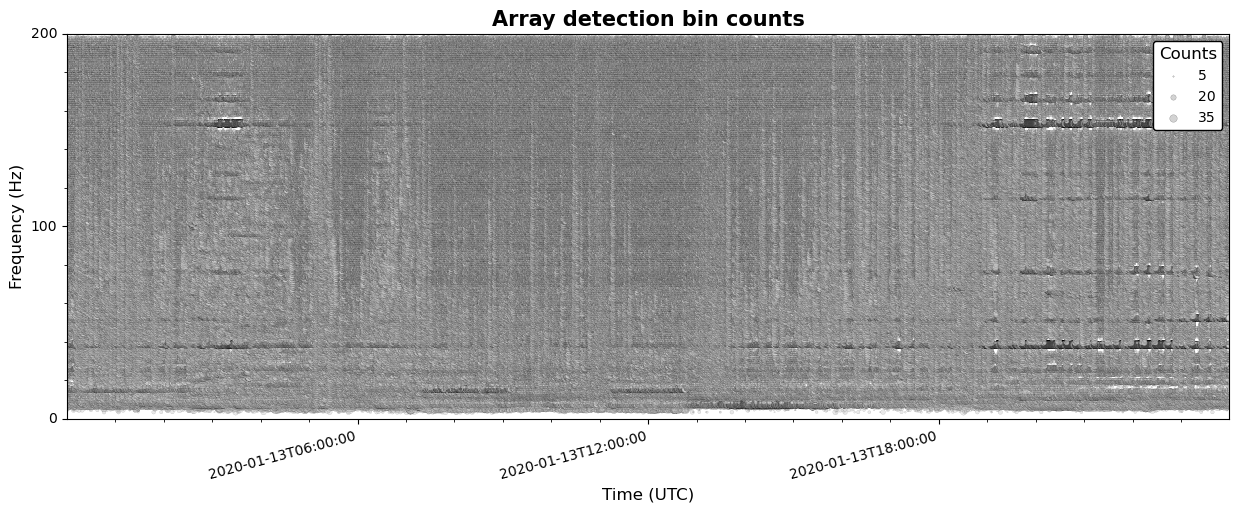

In [20]:
# Plot the bin counts in the example time range
fig, ax = plot_array_spec_peak_bin_counts(bin_count_df,
                                        size_scale = size_scale, 
                                        starttime = starttime_plot, endtime = endtime_plot, freq_lim = (min_freq, max_freq),
                                        date_format = "%Y-%m-%dT%H:%M:%S",
                                        major_time_spacing = "6h", minor_time_spacing = "1h")